In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import torch
%matplotlib inline

In [2]:
G = nx.karate_club_graph()

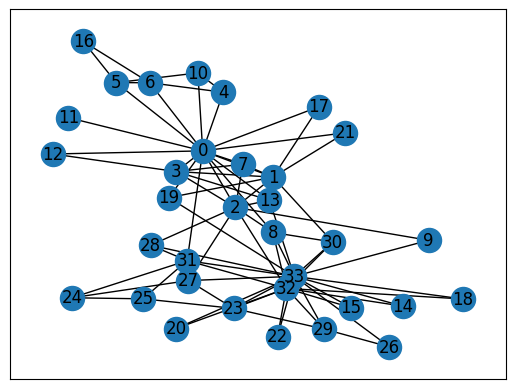

In [3]:
nx.draw_networkx(G, with_labels=True)

In [4]:
for method in dir(G):
  if not method.startswith("_"):
    print(method)

add_edge
add_edges_from
add_node
add_nodes_from
add_weighted_edges_from
adj
adjacency
adjlist_inner_dict_factory
adjlist_outer_dict_factory
clear
clear_edges
copy
degree
edge_attr_dict_factory
edge_subgraph
edges
get_edge_data
graph
graph_attr_dict_factory
has_edge
has_node
is_directed
is_multigraph
name
nbunch_iter
neighbors
node_attr_dict_factory
node_dict_factory
nodes
number_of_edges
number_of_nodes
order
remove_edge
remove_edges_from
remove_node
remove_nodes_from
size
subgraph
to_directed
to_directed_class
to_undirected
to_undirected_class
update


In [5]:
n = len(G.nodes())
n

34

## Euclidean distance-based

In [36]:
W = torch.zeros((n, n))
hop = 3
for shortest_paths in nx.all_pairs_shortest_path_length(G):
  source = shortest_paths[0]
  for dest, l in shortest_paths[1].items():
    # Binarize with the max hop length
    W[source, dest] = 1 if l >= hop else 0

In [37]:
nx.shortest_path(G)

{0: {0: [0],
  1: [0, 1],
  2: [0, 2],
  3: [0, 3],
  4: [0, 4],
  5: [0, 5],
  6: [0, 6],
  7: [0, 7],
  8: [0, 8],
  10: [0, 10],
  11: [0, 11],
  12: [0, 12],
  13: [0, 13],
  17: [0, 17],
  19: [0, 19],
  21: [0, 21],
  31: [0, 31],
  30: [0, 1, 30],
  9: [0, 2, 9],
  27: [0, 2, 27],
  28: [0, 2, 28],
  32: [0, 2, 32],
  16: [0, 5, 16],
  33: [0, 8, 33],
  24: [0, 31, 24],
  25: [0, 31, 25],
  23: [0, 2, 27, 23],
  14: [0, 2, 32, 14],
  15: [0, 2, 32, 15],
  18: [0, 2, 32, 18],
  20: [0, 2, 32, 20],
  22: [0, 2, 32, 22],
  29: [0, 2, 32, 29],
  26: [0, 8, 33, 26]},
 1: {1: [1],
  0: [1, 0],
  2: [1, 2],
  3: [1, 3],
  7: [1, 7],
  13: [1, 13],
  17: [1, 17],
  19: [1, 19],
  21: [1, 21],
  30: [1, 30],
  4: [1, 0, 4],
  5: [1, 0, 5],
  6: [1, 0, 6],
  8: [1, 0, 8],
  10: [1, 0, 10],
  11: [1, 0, 11],
  12: [1, 0, 12],
  31: [1, 0, 31],
  9: [1, 2, 9],
  27: [1, 2, 27],
  28: [1, 2, 28],
  32: [1, 2, 32],
  33: [1, 13, 33],
  16: [1, 0, 5, 16],
  24: [1, 0, 31, 24],
  25: [1, 0, 31,

In [38]:
# Adjacent matrix
W.shape

torch.Size([34, 34])

In [39]:
W.dtype

torch.float32

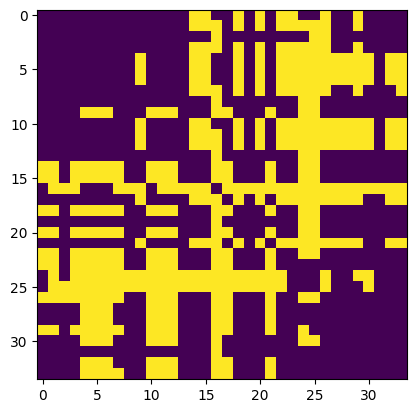

In [40]:
plt.imshow(W);

In [57]:
Z = torch.randn((n, 2), requires_grad=True)

### L2-norm and Laplacian

**Note**: both method can be solved exactly by finding the eigenvalues of the target matrix.

Training these models with the adjacent matrix will lead to embedding by degree. Training with hop-length will embed nodes according to their number of connections.

In [58]:
D = torch.zeros((n, n))
for i in range(n):
  D[i, i] = W[i].sum()

In [62]:
epochs = 100_000
lr = 0.01
decay = 0.01
losses = []
I = torch.eye(2)

for i in range(epochs):
  # *** Forward ***
  # element-wise distance
  W_h = torch.cdist(Z, Z, p=2)
  # L2 norm (multi-dimensional scaling)
#   loss = (((W - W_h)**2).sum() / (W**2).sum()) ** 0.5
  # Laplacian
  loss = (W * W_h).sum() + torch.norm((Z.T @ D @ Z - I), p=2) + torch.norm((Z.T @ D), p=2) + torch.norm(Z, p=2)**2
  # Backward
  Z.grad = None
  loss.backward()
  Z.data += -(lr / (1 + i * decay)) * Z.grad
  losses.append(loss.item())
  if (i % 1_000) == 0:
    print(f"\rloss: {loss.item():10.4f}", end="") 

loss:     1.6654

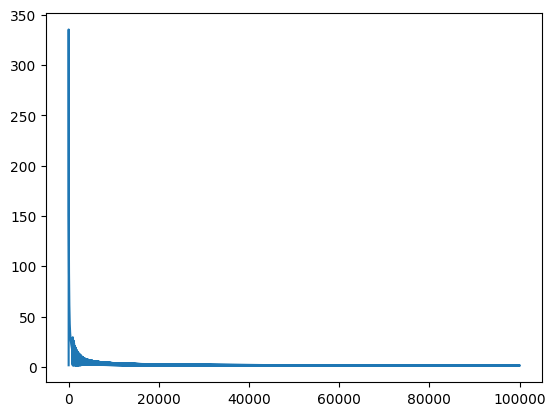

In [63]:
plt.plot(losses)

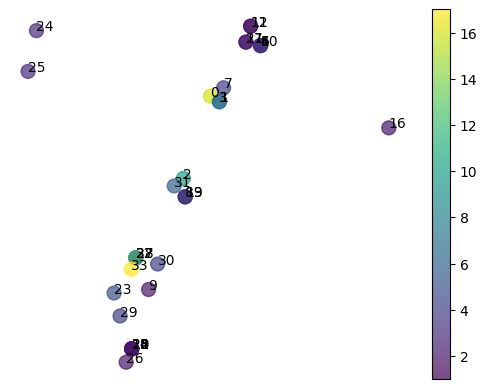

In [64]:
plt.scatter(Z[:, 0].data, Z[:, 1].data, alpha=0.7, s=100, c=[d[1] for d in G.degree])
plt.axis("off");
for i in range(34):
  plt.annotate(i, (Z[i, 0], Z[i, 1]))
plt.colorbar();

## Outer-product based

In [65]:
n = G.number_of_nodes()
W = torch.zeros((n, n))
for edge in G.edges:
  W[edge[0], edge[1]] = 1
  W[edge[1], edge[0]] = 1

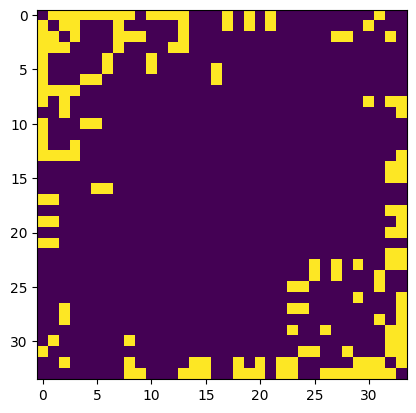

In [66]:
plt.imshow(W);

In [67]:
Z = torch.randn((n, 2), requires_grad=True)

### Graph factorization

We can *easily* solve the problem by optimazing using the gradient. But why not to try and learn how to train a Torch model?

In [96]:
epochs = 200_000
reg = 0.01
lr = 0.01

for i in range(1, epochs):
  # Forward
  W_h = Z @ Z.T
  d = torch.norm(W - W_h)**2
  loss = 0.5 * d + 0.5 * reg * (torch.norm(Z)**2)
  # Backward
  Z.grad = None
  loss.backward()
  Z.data += -(lr / (1 + i // 10)) * Z.grad
  # Print
  if i % 1000 == 0:
    print(f"\rloss [{i:10}]: {loss.item():10.4f}", end="")

loss [    499000]:    43.0608

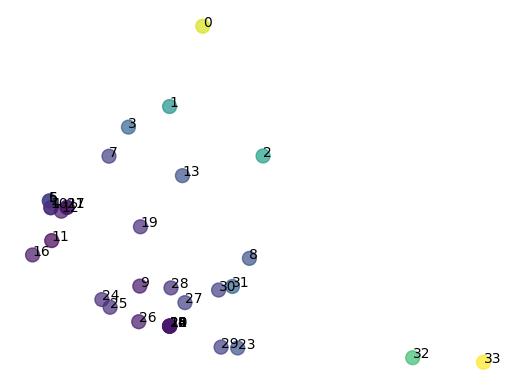

In [97]:
plt.scatter(Z[:, 0].data, Z[:, 1].data, alpha=0.7, s=100, c=[d[1] for d in G.degree])
plt.axis("off");
for i in range(34):
  plt.annotate(i, (Z[i, 0], Z[i, 1]))

From the plot above, we can see that the model learnt to devide into two distinct axis the two communities of the graph: the one starting from node 0 and the one from node 33. The outliers are the hub nodes, while the "vertex" nodex are the leaves. In the middels, there are the connection nodes.